In [1]:
import csv
# import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout
from keras.layers import Convolution2D, ELU
from keras.layers.convolutional import Cropping2D
from keras import regularizers
import matplotlib.image as mpimg
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import pickle
%matplotlib inline

Using TensorFlow backend.


In [2]:
def modify_brightness(img):
    """
    Modify the brightness of a RGB img (imported by matplotlib).
    """
    # get a random number in range [0.5, 1.5]
    change = random.random() + 0.5
    hsv = rgb_to_hsv(img)
    hsv *= change
    rgb = hsv_to_rgb(hsv)
    return rgb

In [3]:
def get_data_center(path):
    """
    Get data from a directory. Each directory has a 'driving_log.csv' file, and
    an 'IMG' folder.
    Only center images.
    Input: path should have the slash in the end, e.g './data/'
    """
    lines = []
    with open(path + 'driving_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            lines.append(line)
    # read the csv file 
    images = []
    # side_images = []
    steering_angles = []
    for line in lines:
        img_center_path = line[0].split('/')[-1]
        current_path = path + 'IMG/'
        img_center = mpimg.imread(current_path + img_center_path)
        images.append(img_center)
        steering_center = float(line[3])
        steering_angles.append(steering_center)
    # convert to numpy array
    X = np.array(images)
    y = np.array(steering_angles)
    return X, y

In [4]:
def get_data_sides(path, correction=0.3, only_Y=False):
    """
    Get data from a directory. Each directory has a 'driving_log.csv' file, and
    an 'IMG' folder.
    Only side images.
    Input: path should have the slash in the end, e.g './data/'
    """
    lines = []
    with open(path + 'driving_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            lines.append(line)
    # read the csv file 
    images = []
    steering_angles = []
    for line in lines:
        if not only_Y:
            img_left_path = line[1].split('/')[-1]
            img_right_path = line[2].split('/')[-1]
            current_path = path + 'IMG/'
            img_left = mpimg.imread(current_path + img_left_path)
            img_right = mpimg.imread(current_path + img_right_path)
            images.extend([img_left, img_right])
        # get steering data
        steering_center = float(line[3])
        # steering_angles.append(steering_center)
        # create adjusted steering measurements for the side camera images
        steering_left = steering_center + correction
        steering_right = steering_center - correction
        steering_angles.extend([steering_left, steering_right])
    # convert to numpy array
    y = np.array(steering_angles)
    if not only_Y:
        X = np.array(images)
        return X, y
    else:
        return y

### Prepare the validation set

In [62]:
X_valid1, y_valid1 = get_data_center('./valid1/')
X_valid2, y_valid2 = get_data_center('./valid2/')
X_valid3, y_valid3 = get_data_center('./valid3/')
X_valid4, y_valid4 = get_data_center('./valid4/')
print(X_valid1.shape)
print(X_valid2.shape)

(1484, 160, 320, 3)
(2182, 160, 320, 3)


In [63]:
X_valid = np.concatenate((X_valid1, X_valid2, X_valid3, X_valid4))
y_valid = np.concatenate((y_valid1, y_valid2, y_valid3, y_valid4))
# X_valid.astype(np.float32)
# y_valid.astype(np.float32)
del X_valid1
del X_valid2
del y_valid1
del y_valid2
del X_valid3
del X_valid4

In [64]:
print(X_valid.shape)

(7093, 160, 320, 3)


In [7]:
# save the validation set to pickle
# train = (X_train, y_train)
valid = (X_valid, y_valid)
# pickle.dump(valid, open("valid.p", "wb"))

### Prepare training data

In [33]:
# Get all the center images
X_center1, y_center1 = get_data_center('./track1/')
X_center2, y_center2 = get_data_center('./track1-recover/')
X_center3, y_center3 = get_data_center('./track2/')
X_center4, y_center4 = get_data_center('./track2-recover/')
# X_train, y_train = get_data_center('./simple-data/')

In [34]:
X_center = np.concatenate((X_center1, X_center2, X_center3, X_center4))
y_center = np.concatenate((y_center1, y_center2, y_center3, y_center4))

In [10]:
del X_center1
del X_center2
del X_center3
del X_center4

In [35]:
print(X_center.shape)
print(y_center.shape)

(12441, 160, 320, 3)
(12441,)


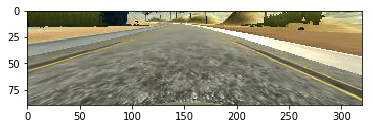

In [36]:
plt.imshow(X_center[100][50:-20,:,:])

In [13]:
# split train-valid sets
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [14]:
print(X_center.shape)
print(X_valid.shape)

(12441, 160, 320, 3)
(3666, 160, 320, 3)


### Augment the training set

#### Flip the images and Change brightness

In [40]:
X_center_flip = []
X_center_bright = []
for img in X_center:
    # flip the images
    X_center_flip.append(np.fliplr(img))
    # change brightness
    X_center_bright.append(modify_brightness(img))
X_center_flip = np.array(X_center_flip, dtype=np.uint8)
X_center_bright = np.array(X_center_bright, dtype=np.uint8)
y_center_flip = -1 * y_center

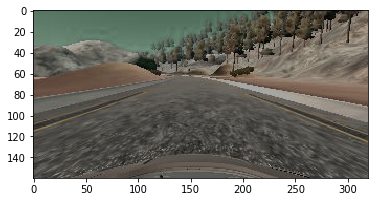

In [41]:
plt.imshow(X_center_bright[54]/255.)

#### Combine the training set (without the left, right images)

In [42]:
X_center = np.concatenate((X_center, X_center_flip, X_center_bright))
y_center = np.concatenate((y_center, y_center_flip, y_center))

In [43]:
del X_center_flip
del X_center_bright
del y_center_flip

In [44]:
# y_center = y_center.astype(np.float32)
print(X_center.dtype)
print(y_center.dtype)
print(X_center.shape)
print(y_center.shape)

uint8
float64
(37323, 160, 320, 3)
(37323,)


In [20]:
# save the training set to pickle
# train = (X_train, y_train)
center = (X_center, y_center)
# pickle.dump(valid, open("train_center.p", "wb"))

#### Get the left, right images

In [21]:
X_side1, y_side1 = get_data_sides('./track1/')
X_side2, y_side2 = get_data_sides('./track1-recover/')
X_side3, y_side3 = get_data_sides('./track2/')
X_side4, y_side4 = get_data_sides('./track2-recover/')

In [22]:
X_side = np.concatenate((X_side1, X_side2, X_side3, X_side4))
# X_side = X_side.astype(np.float32)
y_side = np.concatenate((y_side1, y_side2, y_side3, y_side4))
# y_side = y_side.astype(np.float32)

In [23]:
del X_side1
del X_side2
del X_side3
del X_side4

In [ ]:
side = (X_side, y_side)
# pickle.dump(valid, open("train_side.p", "wb"))

### Checkpoint

In [ ]:
# can load the preprocessed dataset here

#### Get different value for steering correction

In [96]:
# get different values of steering values:
correct = 0.25
y_side1 = get_data_sides('./track1/', correction=correct, only_Y=True)
y_side2 = get_data_sides('./track1-recover/', correction=correct, only_Y=True)
y_side3 = get_data_sides('./track2/', correction=correct, only_Y=True)
y_side4 = get_data_sides('./track2-recover/', correction=correct, only_Y=True)

In [97]:
y_side = np.concatenate((y_side1, y_side2, y_side3, y_side4))

In [ ]:
y_side.astype(np.float32)
print(X_side.shape)
print(y_side.shape)

#### Combine center and side images

In [ ]:
X_train = np.concatenate((X_center, X_side))
y_train = np.concatenate((y_center, y_side))

### Train the network

#### Using NVIDIA architecture

In [ ]:
input_shape = (160, 320, 3)
model = Sequential()
model.add(Lambda(lambda x: x/127.5 - 1., input_shape=input_shape))
model.add(Cropping2D(cropping=((50,20),(0,0))))
model.add(Convolution2D(24,5,5, subsample=(2,2), activation='elu'))
model.add(Dropout(0.2))
model.add(Convolution2D(36,5,5, subsample=(2,2), activation='elu'))
model.add(Dropout(0.2))
model.add(Convolution2D(48,5,5, subsample=(2,2), activation='elu'))
model.add(Dropout(0.2))
model.add(Convolution2D(64,3,3, activation='elu'))
model.add(Dropout(0.2))
model.add(Convolution2D(64,3,3, activation='elu'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(100, 
#                 W_regularizer=regularizers.l2(10e-3),
#                 b_regularizer=regularizers.l2(10e-3),
                activity_regularizer=None))
model.add(Dropout(0.2))
model.add(Dense(50,
#                 W_regularizer=regularizers.l2(10e-3),
#                 b_regularizer=regularizers.l2(10e-3),
                activity_regularizer=None))
model.add(Dropout(0.2))
model.add(Dense(10,
#                 W_regularizer=regularizers.l2(10e-3),
#                 b_regularizer=regularizers.l2(10e-3),
                activity_regularizer=None))
model.add(Dropout(0.2))
model.add(Dense(1))

#### Compile and train the model

In [99]:
model.compile(loss='mse', optimizer='adam')

In [ ]:
# train with center images
history_object = model.fit(X_center, y_center, validation_data=(X_valid,y_valid),
                           shuffle=True, nb_epoch=1)

Train on 37323 samples, validate on 7093 samples
Epoch 1/1
 2752/37323 [=>............................] - ETA: 58s - loss: 0.0731

In [122]:
# train with side images
model.fit(X_side, y_side, validation_data=(X_valid,y_valid),
                           shuffle=True, nb_epoch=1)

Train on 24882 samples, validate on 7093 samples
Epoch 1/1
24882/24882 [==============================] - 46s - loss: 0.0945 - val_loss: 0.0791


In [ ]:
# print the output of model
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [121]:
model.save('model.h5')

In [ ]:
# Comma.AI model
# input_shape = (160, 320, 3)
# model = Sequential()
# model.add(Lambda(lambda x: x/127.5 - 1.,
#         input_shape=input_shape))
# model.add(Cropping2D(cropping=((50,20),(0,0))))
# model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same"))
# model.add(ELU())
# model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
# model.add(ELU())
# model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
# model.add(Flatten())
# model.add(Dropout(.2))
# model.add(ELU())
# model.add(Dense(512))
# model.add(Dropout(.5))
# model.add(ELU())
# model.add(Dense(1))